<a href="https://colab.research.google.com/github/Nishi-sys/Deep_Learning/blob/main/DL/2_Big_Mart_Sales_prediction/Big_Mart_Sales_Prediction_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
import keras
import tensorflow
from keras.layers import InputLayer, Dense
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import csv
from google.colab import files
%matplotlib inline

In [132]:

%%python

import logging
logger = logging.getLogger(__name__)

# logging.basicConfig(
#     filename='Big_Mart_Sales_Prediction.log', # write to this file
#     filemode='a', # open in append mode
#     format='%(name)s - %(levelname)s - %(message)s',
#     level=logging.DEBUG)

fh = logging.FileHandler('Big_Mart_Sales_Prediction.log')
format = logging.Formatter('%(asctime)s- %(levelname)s- %(message)s')
fh.setFormatter(format)
logger.addHandler(fh)
# Set the logging level
logger.setLevel(logging.DEBUG)

logger.warning('This will get logged to a file')
##############################################################################################################################


In [133]:
#DATA CLEANING FUNCTION

def data_clean(df):

  ## Missing values
  try:
    for col in df.select_dtypes(include=['float64','int64']).columns:
      df[col].fillna(df[col].mean(),inplace=True)
    for col in df.select_dtypes(include=['object']).columns:
      df[col].fillna(df[col].mode()[0],inplace=True)
    logger.info(f'Missing values imputed for all dtypes in dataframe')
  except Exception as e:
    logger.warning(f'Missing values could not be removed in dataframe',e, stack_info=True, exc_info=True)

  ## Mapping categorical values
  try:
    for col in df.select_dtypes(exclude=['float64','int64']).columns:
      df[col] = pd.Categorical(df[col], categories=df[col].unique()).codes
    logging.info(f'Categorical values mapped in dataframe')
  except Exception as e:
    logging.warning(f'Categorical values didnt map in dataframe.',e, stack_info=True, exc_info=True)

  ## Scaling the values
  try:
    for i in df.columns[1:]:
      df[i] = (df[i] - df[i].min()) / (df[i].max() - df[i].min())
    logger.info(f'Values scaled between 0 and 1 in dataframe')
  except Exception as e:
    logging.warning(f'Unsuccessful scaling of variables in dataframe.',e, stack_info=True, exc_info=True)
#################################################################################################
  return df


## 1. Loading the Data and Preprocessing

---



In [104]:
#LOADING THE DATA

url = 'https://raw.githubusercontent.com/Nishi-sys/Deep_Learning/main/DL/2_Big_Mart_Sales_prediction/train_data.csv'
df = pd.read_csv(url,on_bad_lines='skip')


In [105]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [106]:
## Considering the effect of the age od establishment on sales
df['Outlet_Establishment_Year']= (2024 - df['Outlet_Establishment_Year'])

In [134]:
#PREPROCESSING THE DATA
df_1 = data_clean(df)

In [38]:
df_1.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,0,0.282525,0.00,0.048866,0.000000,0.927507,0.000000,0.416667,0.0,0.0,0.000000,0.283587
1,1,0.081274,0.25,0.058705,0.066667,0.072068,0.111111,0.000000,0.0,0.5,0.333333,0.031419
2,2,0.770765,0.00,0.051037,0.133333,0.468288,0.000000,0.416667,0.0,0.0,0.000000,0.158115
3,3,0.871986,0.25,0.000000,0.200000,0.640093,0.222222,0.458333,0.0,0.5,0.666667,0.053555
4,4,0.260494,0.00,0.000000,0.266667,0.095805,0.333333,0.916667,0.5,0.5,0.000000,0.073651


## 2. Creating training and validation set

---


In [14]:
## Defining dependent and independent variables
X = df_1.drop(['Item_Outlet_Sales','Item_Identifier','Outlet_Identifier'],axis=1) #dropping dependent variable(y) and (unique keys to identify shop and items)
y = df_1['Item_Outlet_Sales']


In [15]:
X.shape, y.shape

((8523, 9), (8523,))

In [16]:
df_1['Item_Outlet_Sales']

0       0.283587
1       0.031419
2       0.158115
3       0.053555
4       0.073651
          ...   
8518    0.210293
8519    0.039529
8520    0.088850
8521    0.138835
8522    0.056105
Name: Item_Outlet_Sales, Length: 8523, dtype: float64

In [17]:
# Creating training and validation set
# random state to regenerate the same train and validation set
# test size 0.2 will keep 20% data in validation and remaining 80% in train set
#X_train, X_trest, y_train, y_test

#X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=data['Loan_Status'],random_state=10,test_size=0.2)

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=10,test_size=0.2)

In [32]:
# shape of training and validation set
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((6818, 9), (6818,)), ((1705, 9), (1705,)))

## 3. Defining the architecture of the model

---



In [27]:
# defining input neurons = no. of input features
input_neurons = X_train.shape[1]

# number of output neurons
# When developing a neural network to solve a regression problem, the output layer should have exactly one node.
#Here we are not trying to map inputs to a variety of class labels, but rather trying to predict a single continuous target value for each sample
# define number of output neurons
output_neurons = 1

# number of hidden layers and hidden neurons
# It is a hyperparameter and we can pick the hidden layers and hidden neurons on our own
# define hidden layers and neuron in each layer
number_of_hidden_layers = 2
neuron_hidden_layer_1 = 15
neuron_hidden_layer_2 = 10

In [28]:
# defining the architecture of the model   #Dense(units=#neuron_hidden_layerORoutput, activation)
from keras.models import Sequential
model = Sequential()
model.add(InputLayer(input_shape=(input_neurons,)))
model.add(Dense(units=neuron_hidden_layer_1, activation='sigmoid')) ##  9*15(weight matrix + 15(bias))
model.add(Dense(units=neuron_hidden_layer_2, activation='sigmoid')) ## 15*10(weight matrix + 10(bias))
model.add(Dense(units=output_neurons, activation='linear'))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                150       
                                                                 
 dense_1 (Dense)             (None, 10)                160       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 4. Compiling the model (defining loss function, optimizer)

---



In [30]:
#model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_error'])

## 5. Training the model

---



In [31]:
# training the model

# passing the independent and dependent features for training set for training the model

# validation data will be evaluated at the end of each epoch

# setting the epochs as 200

# storing the trained model in model_history variable which will be used to visualize the training process

model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200,verbose=0)

## 6. Evaluating model performance on validation set

---



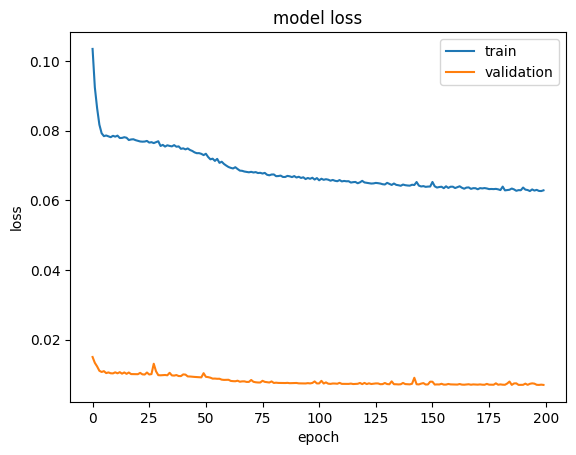

In [33]:
plt.plot(model_history.history['mean_absolute_error'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Testing the model Accuracy:

---



In [34]:
# Error for validation set
predit_X_test=model.predict(X_test)

54/54 [==============================] - 0s 1ms/step


In [35]:
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import mean_absolute_error
print("mean_squared_error",mean_squared_error(predit_X_test,y_test),"\n")
print("mean_absolute_error",mean_absolute_error(predit_X_test,y_test))

mean_squared_error 0.007049113314781891 

mean_absolute_error 0.060874122310926884


In [36]:
# DATA TO BE PREDICTED

##For data to be predicted
url = 'https://raw.githubusercontent.com/Nishi-sys/Deep_Learning/main/DL/2_Big_Mart_Sales_prediction/test_data.csv'
df_test= pd.read_csv(url)


In [37]:
df_test['Outlet_Establishment_Year']= (2024 - df_test['Outlet_Establishment_Year'])

In [38]:
df_test.head() #Overview of the data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,25,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,17,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,26,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,17,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,39,Medium,Tier 3,Supermarket Type3


In [39]:
df_test_X= df_test.drop(['Item_Identifier','Outlet_Identifier'],axis=1)   # this dataset has no no sales column as we need to predict that

In [40]:
df_test_cleaned = data_clean(df_test_X)

In [41]:
# Predicting the sales
predictions = (model.predict(df_test_cleaned))


178/178 [==============================] - 0s 1ms/step


In [42]:
# Scaling the prediction back

predictions_scaled_back= (predictions * ((df['Item_Outlet_Sales'].max() - df['Item_Outlet_Sales'].min()))) + df['Item_Outlet_Sales'].min()

In [43]:
df_test_result_set = df_test[['Item_Identifier','Outlet_Identifier']]
df_test_result_set['Predicted Sales'] = predictions_scaled_back


<ipython-input-43-9589b9ee4b63>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_result_set['Predicted Sales'] = predictions_scaled_back


In [44]:
df_test_result_set.head()

,Item_Identifier,Outlet_Identifier,Predicted Sales
0,FDW58,OUT049,1364.983887
1,FDW14,OUT017,1091.712158
2,NCN55,OUT010,1643.741821
3,FDQ58,OUT017,1584.418823
4,FDY38,OUT027,-297.433929


In [131]:
df_test_result_set.to_csv('df_test_result_set.csv', index=False)
files.download('df_test_result_set.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>